In [8]:
cd /app/

/app


In [9]:
import os
import cv2
import pandas as pd
import numpy as np

from typing import List, Tuple

from modules.utils import sample_load_images, show_images, plot_color_histogram, save_images, random_split_train_val_test_stratified

## Data Exploration

Using the root directory path, we get the whole list of image paths once and keep them in memory.

In [10]:
root_dir = 'data/images_raw'

# assume we have all images with .png extension.
all_images_path_list = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.png')]
# all_images = [cv2.imread(img_path) for img_path in all_images_path_list]

First, we load the csv

In [11]:
labels_file_path = 'data/gicsd_labels.csv'

In [12]:
df = pd.read_csv(labels_file_path)

In [13]:
print(len(df))

800


It seems like we have a total of 800 images.

In [14]:
print(df.columns)

Index(['IMAGE_FILENAME', ' LABEL'], dtype='object')


We have a whitespace issue in label column name. We better fix it.

In [15]:
df = df.rename(columns={' LABEL': 'LABEL'})

In [16]:
print(df.columns)

Index(['IMAGE_FILENAME', 'LABEL'], dtype='object')


Let's also check the unique labels names in our dataset.

In [17]:
print(df['LABEL'].unique())

[' FULL_VISIBILITY ' ' PARTIAL_VISIBILITY ' ' NO_VISIBILITY ']


We can also strip the whitespace characters on our label names.

In [18]:
df['LABEL'] = df['LABEL'].apply(lambda x: x.strip())

In [19]:
print(df['LABEL'].unique())

['FULL_VISIBILITY' 'PARTIAL_VISIBILITY' 'NO_VISIBILITY']


We can check for missing values.

In [20]:
df.isnull().any()

IMAGE_FILENAME    False
LABEL             False
dtype: bool

We don't have any missing values!

We can check the distribution of image dimensions. We would expect all images have the same dimensions. We can use the blue-channel images we extracted to get the dimensions.

In [21]:
all_images = [cv2.imread(img_path) for img_path in all_images_path_list]
img_height = [img.shape[0] for img in all_images]
img_width = [img.shape[1] for img in all_images]
df_dim = pd.DataFrame(data={'width': img_width, 'height': img_height})

In [22]:
df_dim['width'].value_counts(), df_dim['height'].value_counts() 

(192    800
 Name: width, dtype: int64,
 192    800
 Name: height, dtype: int64)

It looks like we all have 192x192 images.

Now, we can check the distribution of labels.

<AxesSubplot:>

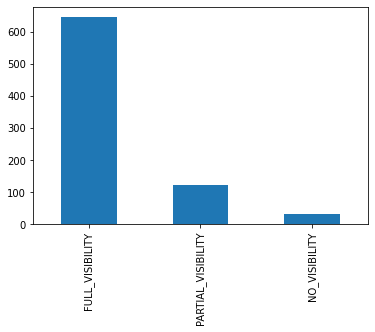

In [23]:
df['LABEL'].value_counts().plot(kind='bar')

In [24]:
print(df['LABEL'].value_counts() / df['LABEL'].value_counts().sum())

FULL_VISIBILITY       0.80750
PARTIAL_VISIBILITY    0.15375
NO_VISIBILITY         0.03875
Name: LABEL, dtype: float64


It seems we have an imbalanced class distribution. 80.7% of the data belongs to images of FULL_VISIBILITY category, 15.3% belongs to PARTIAL_VISIBILITY category and only 3.8% belongs to NO_VISIBILITY category.

## Feature Engineering

Let's first view several randomly sampled images

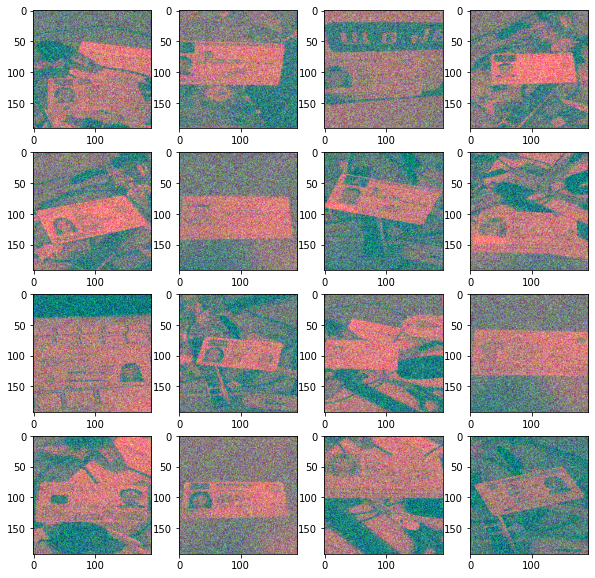

In [25]:
sampled_images = sample_load_images(all_images_path_list)
show_images(sampled_images)

We can run the above line several times to see as many different images as we like. By observing the images, it looks like we have a similar noise pattern (red-green) in all the images. We can plot the histogram of each color channel to see if we can get something.

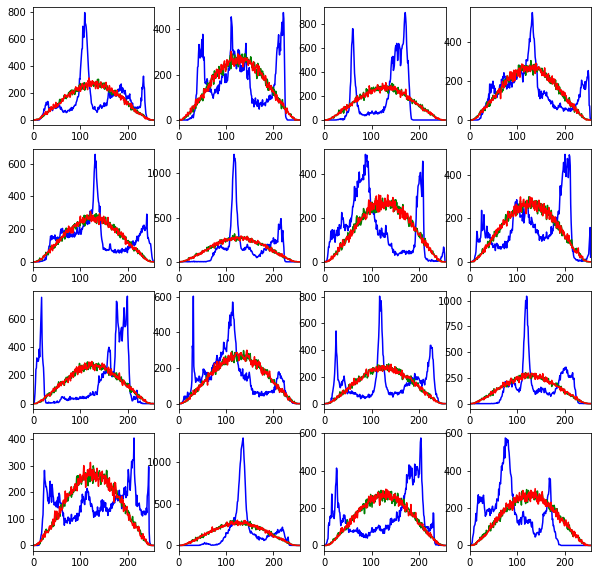

In [26]:
plot_color_histogram(sampled_images)

By observing the above histogram plots; the pixel intensity distribution of red and green channels are highly correlated showing a Gaussian form with different mean and std deviation. This is likely explaining the sensor noise. 

However, the distribution in blue channel is highly non-uniform and carries much information which is likely explaining the image signal. Therefore, we can remove the red-green channels from images and see what we get with only blue channel.

Below, we just transform (extracting the blue channel) the previous 16 images to see if we are able to remove the noise. 

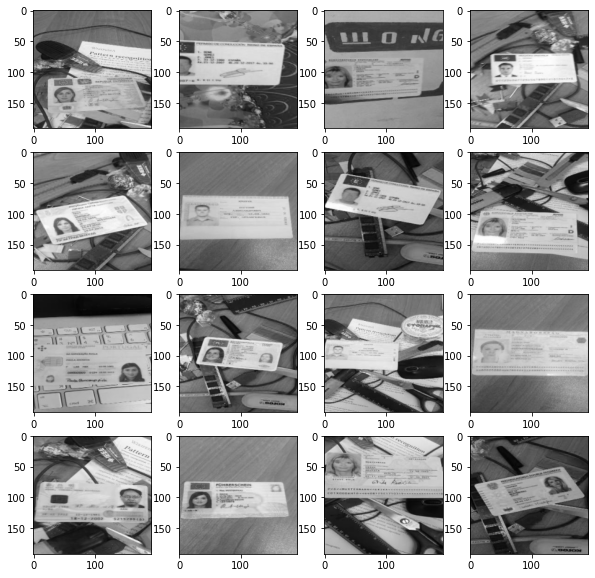

In [27]:
for img in sampled_images:
    # here we are replacing the red and gree channels with blue-channel image
    img[:, :, 1] = img[:, :, 0]
    img[:, :, 2] = img[:, :, 0]

show_images(sampled_images)

It seems our hypothesis was true! Red and green channels were indeed corrupted by noise and we pretty much obtained noise-free images by getting the blue channel. 

Let's remove the noise on the whole set of images and save them into a folder.

In [28]:
all_images_blue = [img[:,:,0] for img in all_images]

In [29]:
all_images_src_name_list = [os.path.basename(path) for path in all_images_path_list]
all_images_dst_name_list = [f"{os.path.splitext(name)[0]}.png" for name in all_images_src_name_list]

In [30]:
dst_images_dir = 'data/images_processed'
save_images(all_images_blue, all_images_dst_name_list, dst_images_dir)

We saved the noise-free images. Now, we can try to load and view a subset of them to make sure everything is in order.

In [31]:
# assume we have all images with .jpg extension.
all_processed_images_path_list = [os.path.join(dst_images_dir, f) for f in os.listdir(dst_images_dir) if f.endswith('.png')]

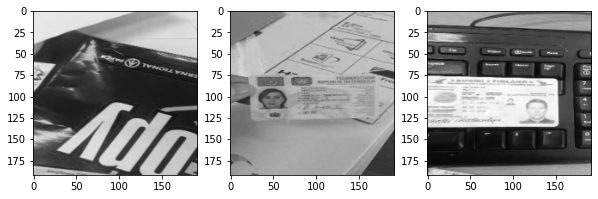

In [32]:
sampled_processed_images = sample_load_images(all_processed_images_path_list, 3)
show_images(sampled_processed_images)

## Modeling

### Data Partitioning

To develop an image classification model with the available data, we need to describe a statistically viable approach. We need to make sure the model is trained in a subset of the whole set which will not be used during evaluation of the model. Otherwise our model will likely have overfitting issues. The common approach is to assign a greater amount of the whole data as training subset. The remaining smaller amounts are assigned as validation and testing subsets where testing subset if often greater than the validation subset.

We want to make sure our training subset represent all classes, so that different partitions have a distribution of classes similar to the original distribution. Otherwise, some of the classes would have the risk of being underrepresented in training set. Therefore, we better perform a stratified sampling for training, validation and testing subsets.

Validation set is used to determine the hyperparameters of the model, i.e., otherwise we have the risk of overfitting our model parameters to the training set. We can have an idea of our model performance with the validation set, i.e., how the parameters work and whether overfitting occurs or not, but we use the testing set to assess the final performance of our model.

We can set a training, validation, and testing split ratios of 70%, %10, and %20, respectively. This should be a resonable choice.

In [33]:
train_pct = 0.7
val_pct = 0.1
test_pct = 0.2

In [34]:
df_train, df_val, df_test = random_split_train_val_test_stratified(df, label_colname='LABEL')

In [35]:
print(len(df_train), len(df_val), len(df_test))

559 81 160


Now, we can check the label distribution in each split.

In [36]:
print(df_train['LABEL'].value_counts() / df_train['LABEL'].value_counts().sum())

FULL_VISIBILITY       0.806798
PARTIAL_VISIBILITY    0.153846
NO_VISIBILITY         0.039356
Name: LABEL, dtype: float64


In [37]:
print(df_val['LABEL'].value_counts() / df_val['LABEL'].value_counts().sum())

FULL_VISIBILITY       0.814815
PARTIAL_VISIBILITY    0.148148
NO_VISIBILITY         0.037037
Name: LABEL, dtype: float64


In [38]:
print(df_test['LABEL'].value_counts() / df_test['LABEL'].value_counts().sum())

FULL_VISIBILITY       0.80625
PARTIAL_VISIBILITY    0.15625
NO_VISIBILITY         0.03750
Name: LABEL, dtype: float64


## Feature extraction and Classification

We cannot simply use the image pixels for classification. This could lead to very high dimensional input space and we can quickly overfit (we would need very huge training set otherwise). 

We need to find a way to extract features from images. Features will likely yield a compressed/lower dimensional input, and higher discriminability than image pixels, and use them for classification. 

One way to do this is to use Histogram of Oriented Gradients method for feature extraction. The method, i.e., https://ieeexplore.ieee.org/abstract/document/1467360, has originally been used  for human detection and cited more than 30k times according to Google scholar. 

We can use the extracted feature vectors to classify images with nearest neighbor classification. Nearest neighbor classification is a nonparametric method and can work well if we have enough memory to store the feature vectors.

In [57]:
def get_hog_features(df_split: pd.DataFrame, images_rootdir: str) -> Tuple[np.array, np.array, List]:
    """Compute HoG features for images in given data split and return.

    Args:
        df_split (pd.DataFrame): Dataframe of image filenames and labels.
        images_rootdir (str): Root directory storing images.

    Returns:
        Tuple[np.array, np.array, list]: tuple of feature vectors, labels and filenames.
    """
    hog = cv2.HOGDescriptor()
    
    features = []
    filenames = []
    labels = []

    for _, row in df_split.iterrows():
        image_path = os.path.join(images_rootdir, row['IMAGE_FILENAME'])
        if os.path.isfile(image_path):
            # extracting and feeding the blue channel input
            h = hog.compute(cv2.imread(image_path)[:,:,0])
            features.append(h.ravel())
            filenames.append(row['IMAGE_FILENAME'])
            labels.append(row['LABEL'])
    
    return np.array(features), np.array(labels), filenames

In [58]:
def nearest_neighbor_classification(query_features: np.array, gallery_features: np.array, gallery_labels: np.array) -> np.array:
    """Perform 1-nearest neighbor classification between each query feature vector
    and all gallery feature vectors.

    Args:
        query_features (np.array): query feature vectors shape (n_q, feat_dim)
        gallery_features (np.array): gallery feature vectors of shape (n_g, feat_dim)
        gallery_labels (np.array): gallery labels of shape (n_g,)

    Returns:
        np.array: gallery labels of shape (n_q,)
    """
    distances = []
    for i in range(query_features.shape[0]):
        dist_i = []
        query_feat = query_features[i,:]
        for j in range(gallery_features.shape[0]):
            gallery_feat = gallery_features[j,:]
            dist = np.linalg.norm(query_feat - gallery_feat)
            dist_i.append(dist)
        distances.append(dist_i)

    distances_np = np.array(distances)

    min_dist = np.argmin(distances_np, axis=1)

    predicted_labels = [gallery_labels[idx] for idx in min_dist]

    return predicted_labels

In [59]:
train_features, train_labels, train_filenames = get_hog_features(df_train, root_dir)

In [60]:
val_features, val_labels, val_filenames = get_hog_features(df_val, root_dir)

In [61]:
test_features, test_labels, test_filenames = get_hog_features(df_test, root_dir)

We can first compute the overall image classification accuracy based on the count of correctly classified images.

In [62]:
test_predicted_labels = nearest_neighbor_classification(test_features, train_features, train_labels)

In [63]:
df_test_pred = pd.DataFrame(data={'true': test_labels, 'filename': test_filenames, 'predicted': test_predicted_labels})

In [64]:
df_test_pred

,true,filename,predicted
0,FULL_VISIBILITY,GICSD_19_0_13.png,FULL_VISIBILITY
1,FULL_VISIBILITY,GICSD_36_9_293.png,FULL_VISIBILITY
2,FULL_VISIBILITY,GICSD_38_5_173.png,FULL_VISIBILITY
3,FULL_VISIBILITY,GICSD_49_2_73.png,PARTIAL_VISIBILITY
4,FULL_VISIBILITY,GICSD_32_2_73.png,FULL_VISIBILITY
...,...,...,...
155,NO_VISIBILITY,GICSD_12_7_213.png,NO_VISIBILITY
156,PARTIAL_VISIBILITY,GICSD_42_6_193.png,FULL_VISIBILITY
157,PARTIAL_VISIBILITY,GICSD_41_7_213.png,NO_VISIBILITY
158,FULL_VISIBILITY,GICSD_33_7_233.png,FULL_VISIBILITY


In [65]:
(df_test_pred['predicted'] == df_test_pred['true']).mean()

0.7125

NN classification obtained 71.25 percent correct classification accuracy for the test set. However, accuracy metric by simply counting the true predictions may be misleading in imbalanced settings. Because the prevalent class will be dominant in the result. Therefore we need to take into account metrics such as precision, recall and f1-score to take into account the class imbalance.

In [66]:
from sklearn.metrics import precision_recall_fscore_support

In [67]:
precision, recall, fscore, support = precision_recall_fscore_support(df_test_pred['true'], df_test_pred['predicted'])

In [68]:
df_hog_test_results = pd.DataFrame([precision, recall, fscore, support],
             columns=['FULL_VISIBILITY', 'PARTIAL_VISIBILITY', 'NO_VISIBILITY'],
             index=['precision', 'recall', 'fscore', 'support'])

In [69]:
df_hog_test_results

,FULL_VISIBILITY,PARTIAL_VISIBILITY,NO_VISIBILITY
precision,0.857143,0.148148,0.285714
recall,0.837209,0.666667,0.080000
fscore,0.847059,0.242424,0.125000
support,129.000000,6.000000,25.000000


It seems that the model performance for NO_VISIBILITY and PARTIAL_VISIBILITY classes are much lower. Below we replot the support of these classes in training set.

In [70]:
print(df_train['LABEL'].value_counts() / df_train['LABEL'].value_counts().sum())

FULL_VISIBILITY       0.806798
PARTIAL_VISIBILITY    0.153846
NO_VISIBILITY         0.039356
Name: LABEL, dtype: float64


These classes have extremely low support in the training set. (During training our next model, we will oversample the minority class samples to have a balanced class distribution)

But overall, we can improve these results with another method! 

A recent approach to do this is to train deep convolutional neural networks (CNNs). CNNs are special type of feed forward neural networks (FFNN) where image features are learned end-to-end in a hierarhical manner. Convolutional layers employ weight sharing and local connectivity which helps to reduce the degrees of freedom substantially compared to FFNNs. Features evolve from being generic in earlier layers to more specific in final layers. It is a good practice to initialize such kind of network with pretrained weights if our own task-specific dataset is not as big as the source dataset. Then, we can fine-tune the pretrained network weights with our data and labels. We would like to train only the final fully-connected layer weights to avoid risk of overfitting in our case, because we have a very limited set of input (our training set is only 560 images). Since these networks are often pretrained with huge datasets, i.e., ImageNet contains 1.2 million images in its training set, they have a very strong representational power. In earlier layers generic features are learned, hence they can be used for feature extraction purposes.

In [4]:
!python scripts/train.py --data_csv_path data/gicsd_labels.csv --images_root_dir data/images_processed --artifacts_dir /app/artifacts

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/developer/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name    | Type             | Params
---------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0     
1 | network | Resnet           | 11.2 M
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)
/home/developer/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /app/artifacts exists and is not empty.
  rank_zero_warn(f"Checkpoint di

We can see how training/validation evolved by inspecting the loss curves below. I was able to grab a snapshot of them from Tensorboard screen once the training stopped due to early stopping criterion (due to diverging validation loss).

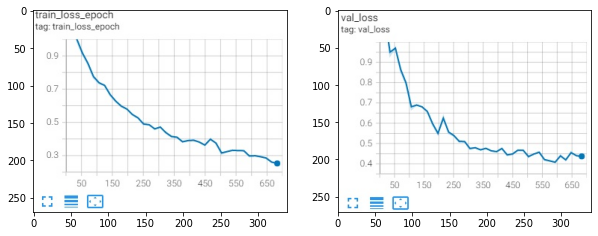

In [6]:
from matplotlib import pyplot as plt
_, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(cv2.cvtColor(cv2.imread('artifacts/training_loss.jpg'), cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(cv2.imread('artifacts/validation_loss.jpg'), cv2.COLOR_BGR2RGB))

It seems validation loss does not improve after 32th epoch. The optimization stopped due to our early stopping criterion. Besides early stopping, other ways to tackle overfitting issue include collecting more data or increasing weight regularization in the optimizer. Due to smaller dataset size, it is better to use a model with low complexity and initialize it with pre-trained weights (as we did here).

In [71]:
# I copied the test results from the output link in above cell (not sure it will exist in html version)
test_results = {'test_accuracy': 0.8188,
 'test_fscore_full_visibility': 0.8923,
 'test_fscore_mean': 0.7108,
 'test_fscore_no_visibility': 0.8,
 'test_fscore_partial_visibility': 0.44,
 'test_loss': 0.4135,
 'test_precision_full_visibility': 0.8855,
 'test_precision_mean': 0.7752,
 'test_precision_no_visibility': 1.0,
 'test_precision_partial_visibility': 0.44,
 'test_recall_full_visibility': 0.8992,
 'test_recall_mean': 0.6686,
 'test_recall_no_visibility': 0.6667,
 'test_recall_partial_visibility': 0.44}

Our CNN model showed better accuracy in testing set, compared to HoG-NN results: 0.81 vs 0.71. Converting the above dict to dataframe below to have easier comparison,

In [72]:
cnn_test_precision = [test_results['test_precision_full_visibility'], test_results['test_precision_partial_visibility'], test_results['test_precision_no_visibility']]
cnn_test_recall = [test_results['test_recall_full_visibility'], test_results['test_recall_partial_visibility'], test_results['test_recall_no_visibility']]
cnn_test_fscore = [test_results['test_fscore_full_visibility'], test_results['test_fscore_partial_visibility'], test_results['test_fscore_no_visibility']]

In [73]:
df_cnn_test_results = pd.DataFrame([cnn_test_precision, cnn_test_recall, cnn_test_fscore],
             columns=['FULL_VISIBILITY', 'PARTIAL_VISIBILITY', 'NO_VISIBILITY'],
             index=['precision_cnn', 'recall_cnn', 'fscore_cnn'])

In [74]:
pd.concat((df_hog_test_results, df_cnn_test_results))

,FULL_VISIBILITY,PARTIAL_VISIBILITY,NO_VISIBILITY
precision,0.857143,0.148148,0.285714
recall,0.837209,0.666667,0.080000
fscore,0.847059,0.242424,0.125000
support,129.000000,6.000000,25.000000
precision_cnn,0.885500,0.440000,1.000000
recall_cnn,0.899200,0.440000,0.666700
fscore_cnn,0.892300,0.440000,0.800000


Observing the above table, CNN performed better than HoG based classifier for each metric and each class. Looking at fscore, which is the harmonic mean of precision and recall, CNN performed 0.8 for NO_VISIBILITY class whereas HoG performed only 0.12. 